In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys

In [5]:
sys.path.append('..')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklego.preprocessing import ColumnSelector

In [7]:
from this_project.censusdata import fetch_censusdata
from this_project.eda.plot import plot_roc_pr_curves
from this_project.censusdata.datasets import NUM_COLS, CAT_COLS

In [8]:
from sklearn import set_config
set_config(display='diagram')

In [9]:
X, y = fetch_censusdata()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
preprocessor = make_union(
    make_pipeline(
        ColumnSelector(CAT_COLS),
        SimpleImputer(strategy="constant", fill_value="MISSING"),
        OneHotEncoder(handle_unknown="ignore"),
    ),
    make_pipeline(
        ColumnSelector(NUM_COLS),
        SimpleImputer(strategy="median"),
        StandardScaler()
    )
)

In [12]:
X_train_tr = preprocessor.fit_transform(X_train, y_train)
X_test_tr = preprocessor.transform(X_test)

In [13]:
clf = LogisticRegression()

In [14]:

clf.fit(X_train_tr, y_train)

LogisticRegression()

In [15]:
print("model score: %.3f" % clf.score(X_test_tr, y_test))

model score: 0.849


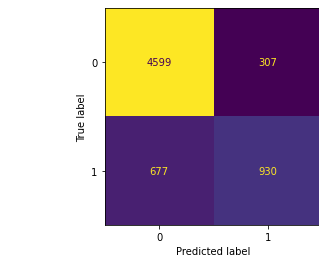

In [16]:
y_pred = clf.predict(X_test_tr)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

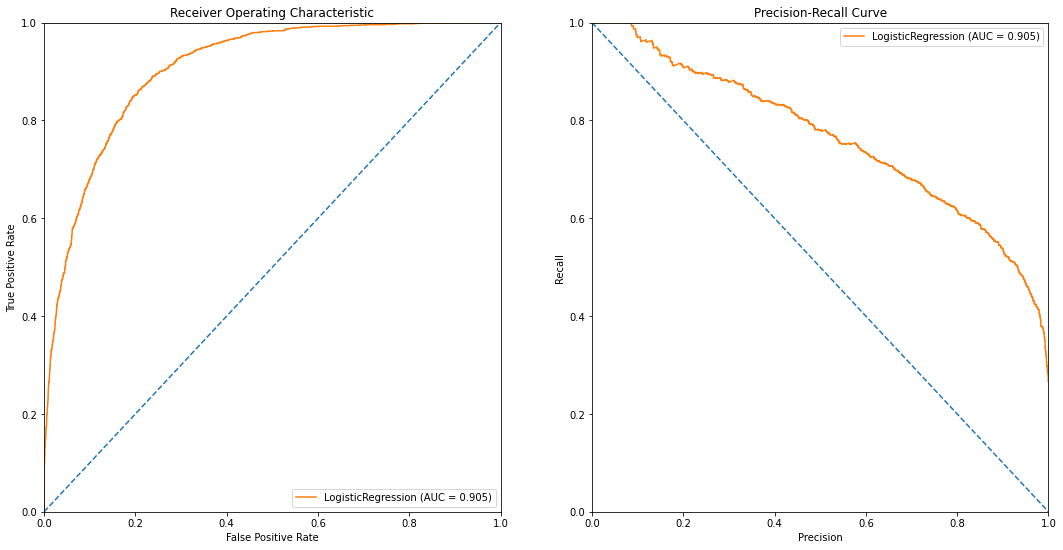

In [17]:
fig = plot_roc_pr_curves(clf, X_test_tr, y_test)

plt.savefig('baseline.roc_pr_curve.png')

In [18]:
y_pred = clf.predict(X_test_tr)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f'precision: {precision:.5f}; recall: {recall:.5f}; f-score: {fscore:.5f}')

precision: 0.75182; recall: 0.57872; f-score: 0.65401


# SHAP

SHAP (https://github.com/slundberg/shap) is an extremely powerful technique to measure feature importance. However, when the cardinality of the OHE features is high, it might be tricky to keep track of the large amount of new binary features being generated, as in the example below.

On the other hand, for tree-based algorithms (like xgboost or catboost), SHAP is probably the easier and more powerful way to perform this analysis.

In [19]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [21]:
explainer = shap.LinearExplainer(clf, X_train_tr, feature_dependence="independent")

In [22]:
shap_values = explainer.shap_values(X_test_tr)

In [23]:
X_test_array = X_test_tr.toarray()

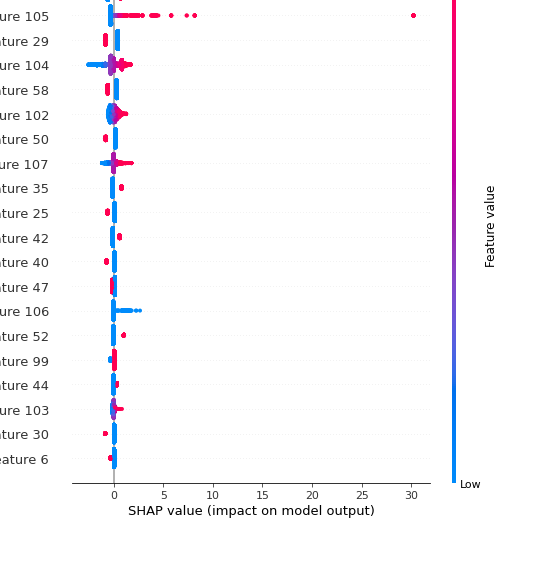

In [24]:
shap.summary_plot(shap_values, X_test_array)